# Motorcycle Prices

**How much should I expect to pay for my dream motorbike?**

<img src="Superbikes-lineup.jpg">

I have previously owned a [Suzuki Across] and was forced to sell the bike due to the fact that I couldn't afford to own a car and a bike at the same time. This has now changed, My career has progressed and I am approaching "mid-life", so its a perfect to go through my "mid life crisis" and buy a motorbike 😉.

The motovation for the purchase is purely enjoyment, and will not neccessarily be used for commuting. This means that emotion can easily get in the way and it may end up costing more that neccessary. So I would like to remove the "emotional" choices from this decision as much as possible.

It is commonly accepted that a car's sale price is related to a few [features]; The age, Model, Condition, and kilomters on the odmeter. Is this the same for motorbikes?

There may be a cause to say that bikes could be considered differntly as they are predominantly used for enjoyment and not commuting to and from work or down to the shops. Additionally the smaller [learner legal] bikes may retain more value because all new riders are restricted to these types of bikes.

**Some questions to ask of the data.**

* What features are able to predict the price of a motorbike?
* How much can I save if I buy an older bike?
* How much can I save if there are more kilometers? and how many more kilometers does it take?
* How does the model of the bike affect the sale price?
* Does the location affect the sale price?

[Suzuki Across]:(https://en.wikipedia.org/wiki/Suzuki_Across)
[features]:(https://help.carsales.com.au/hc/en-gb/articles/360015482932-Price-Indicators)
[learner legal]:(https://www.rms.nsw.gov.au/roads/licence/rider/approved-novice-motorcycles.html)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')


In [17]:
work = 'C:\\Users\\bbel1\Documents\SourceCode\BikeSales\BikeSalesData2.csv'
home = 'C:\\Users\\Beau\Documents\DataScience\BikeSales\BikeSalesData.csv'
file = home
df = pd.read_csv(file, 
                 parse_dates=['First_Seen','Last_Seen','Last Modified'], 
                 infer_datetime_format=True, 
                 na_values='-')


## EDA
1. Examine what features are available in the data set.
2. Privide meaningfull definitions of each feature.
3. Determine the different data types
4. Find the features that have missing values, and develop a solution.
    1. Remove the feature all together    
    2. Use Domain knowldge to fill in missing values.
    3. Fill the missing values using statistical techniques (mean, mode, ...)

In [18]:
df.columns

Index(['Unnamed: 0', 'Network ID', 'Bike', 'Learner Approved', 'Unnamed: 4',
       'Price', 'Payment', 'Kilometers', 'Body', 'Colour',
       ...
       'Airbag(s)', 'Traction Control Selectable', 'Bluetooth',
       'MP3 Capatible', 'Unnamed: 187', 'Unnamed: 188', 'Unnamed: 189',
       'Acceleration', 'Lean Angle Left', 'Lean Angle Right'],
      dtype='object', length=193)

In [19]:
df.head()

,Unnamed: 0,Network ID,Bike,Learner Approved,Unnamed: 4,Price,Payment,Kilometers,Body,Colour,...,Airbag(s),Traction Control Selectable,Bluetooth,MP3 Capatible,Unnamed: 187,Unnamed: 188,Unnamed: 189,Acceleration,Lean Angle Left,Lean Angle Right
0,0,SSE-AD-5947343,250 R Road Manual 5sp 250cc (Discontinued),Yes,NaN,$500*,Pay securely online with PayProtect,"17,500 km Bike History Report - Investigate th...",Super Sport,Red,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,SSE-AD-5907807,GSX1100 ESD Road Manual 5sp 1100cc (Half fairing),NaN,NaN,$500*,Pay securely online with PayProtect,"23,504 km",Sport Touring,Black,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,SSE-AD-5777351,TS250 Trail Manual 5sp 250cc,NaN,NaN,$500*,Pay securely online with PayProtect,"20,724 km",Trail,Red,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,SSE-AD-5972924,Avenger 125 Mini Bike Manual 4sp 125cc,NaN,NaN,$550*,Pay securely online with PayProtect,"1,000 km Bike History Report - Investigate the...",Fun,Blue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,SSE-AD-5838631,CBR900RR Fireblade (929) (Apr),NaN,NaN,$600*,Pay securely online with PayProtect,"81,276 km Bike History Report - Investigate th...",Super Sport,Gold,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Observations of the data so far
1. There are a number of features `Unnamed:...` that would appear irrelavant and may be a by-product of the scraping process, so we can likely remove these straight away
2. There are features that will need processing to convert the value into something meaningfull, ie. removing the units from various features.
3. There are some possible duplications of features that may require combination (ie. Carburettor and Carburettor(s) )

### Definitions

`Unnamed: 0`: Index value when written to file

`Unnamed: 1`: Empty feature that seems to be a by-product of the scraping process.

`1st Gear Ratio`: The ratio of teeth between the front and rear sockets for 1st gear.

`2nd Gear Ratio`: The ratio of teeth between the front and rear sockets for 2nd gear.

`3rd Gear Ratio`: The ratio of teeth between the front and rear sockets for 3rd gear.

`4th Gear Ratio`: The ratio of teeth between the front and rear sockets for 4th gear.

`5th Gear Ratio`: The ratio of teeth between the front and rear sockets for 5th gear.

`6th Gear Ratio`: The ratio of teeth between the front and rear sockets for 6th gear.

`ABS`: Anti-Lock Breaking System, which stops the breaks from locking.

`ABS Selectable`: Ability to turn the vehicle ABS on and off

`Acceleration`: The time it takes for the vehicle to reack 100 km/h

`Adjustable Front Footrests`: Indicates if the front foot rests can be adjusted for a riders height

`Adjustable Seat`: Indicates if the seat has an adjsutable height

`Airbag(s)`: Indicates if there are air bags fitted to the vehicle

`Alarm`: Indicates if an alarm is an optional extra or already fitted to the vehicle.

`Australian Capital Territory`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Backrest - Pillion`: Indicates if a backrest is available for a pillion rider.

`Backrest - Rider`: Indicates if a backrest is available for the main rider.

`Battery Description`: Description of the Battery, typically indicating the battery type and ampage.

`Bike`: Description of the vehicle, typically the make and model.

`Bluetooth`: Indicates if bluetooth is available as standard.

`Body`: A description of the body type, ie, sports, touring, scooter, etc ...

`Bore`: The Bore indicates the diamater of the bore cyclinder of the engine.

`CD Player`: Indicates if a CD player is available as standard on the vehicle.

`Cam Type`: Description of the engine cam type.

`Carburettor`: Typically describes the carburettor type, but can also represent the number of carburettors on the vehicle.

`Carburettor(s)`: The number of carburettors.

`Charge Time (hrs)`: Time to recharge the battery, typically only relevant for electric motors.

`Charging Method`: The method of charging the engine.

`Chassis Description`: Description of the motorvehicle chassis.

`Clutch Diameter`: The diameter of the clutch plate.

`Clutch Type`: Description of the clutch type.

`Colour`: Main colour of the vehicle

`Compression Ratio`: The proportional ratio of volume inside the combustion chamber from its largest to smallest capacity.

`Configuration`: The configuration of teh engine of the vehicle,

`Coolant Capacity`: Capacity of liquid coollant required.

`Cooling`: Cooling system on the vehicle.

`Country of Origin`: Country of manufacture.

`Crash Bar`: Indicates if a crash bar is fitted, preventing the vehicle from damaging the chassis if dropped.

`Cruise Control`: Indicates if cruise control is fitted to the vehicle

`Cup Holders`: Indicates if cup holders are fitted to the vehicle.

`Cylinders`: The number of cyclinders in the engine.

`Decibel Rating`: ???

`Descent Control`: Indicates if the vehicle has descent control as standard.

`Description`: Detailed description of the condition and extras by the owner.

`Drive Type`: Describes the type fo drive system.

`Driven Wheels`: The number of wheels that are driven by the drive system.

`Driver Restraint`: Indicates if a driver restraint is fitted for safety, this is typically only available on 4 wheel drive vehicles

`Dry Weight`: The weight of the vehicle when no petrol or oil has been added.

`Dual Front Wheels`: ???

`Economy Mode`: Identifies if the vehicle has an economy mode, typically associated with electric vehicles.

`Electronic Power Steering`: Identifies if the vehile has power steering, this is typically associated with 4 wheel vehicles.

`Electronic Suspension Adjustment`: Identifies if the vehicle has electronically controlled adjustable suspension.

`Emission Standard`: Specifies the [European emission standards] acceptable for exhaust emissions of a vehicles sold in the European Union and EEA member states. the standard is generally specific to the year of manufacture, with newer vehicles subject to stricter standards.

`Engine Braking System`: Identifies if the vehicle has a automatic engine cuttoff.

`Engine Capacity`: The size of the engine in cubic centimetres.

`Engine Config`: Description of the engine configuration.

`Engine Description`: Description of the engine size, typically the same as the engine capacity.

`Engine Immobiliser`: Identifies if there is an engine imobiliser installe

`Engine Stroke`: The number of pistons the engine has.

`Engine Type`: The description of the engine type

`Engine Voltage`: The Voltage generated by the Engine

`Exhaust Config`: The configuration of the exhaust system

`Exhaust Description`: Description of the muffler materials.

`Final Drive Ratio`: The ratio of teeth between the 1st and 6th (last) gear .

`First Service Interval`: The km at which the manufacture recomends the first service take place.

`First_Seen`: The date the advertisement was first seen.

`Frame Design`: The design of the frame structure.

`Frame Material`: The materials used in the frame.

`Front Brake Caliper(s)`: Description of the front brakes callipers.

`Front Brake Description`: Description of the front brakes.

`Front Brake Diameter`: The size of the front brake disc.

`Front Differential Lock`: Identifies if the vehicle has a differential lock system on the front wheels, typically associated with 4 wheeled vehicles.

`Front Payload / Carry Weight`: The payload weight permitted to carry on the front 

`Front Receiver`:  ???

`Front Suspension`: Description of the front sussension system

`Front Suspension Travel`: The distance the suspension will travel at full compression.

`Front Tyre`: Description of the front tyre.

`Fuel Reserve Capacity`: Capacity of the reserve tank.

`Fuel Tank Capacity`: Capacity of the fuel tank.

`Fuel Type`: Type of fuel required.

`GPS Navigation`: Identifies if GPS navigation is available.

`Gear Change Method`: The method to change gears.

`Gear Number`: The number of gears, exluding neutral.

`Gear Type`: Description of the transmission.

`Glove Box(s)`: Identifies if the vehicle has a glov box, typically associated with four wheeled vehicles.

`Ground Clearance`: The distance between the ground and the base of the vehicle frame.

`Handlebar Description`: Description of the handlebars.

`Hands Free Ignition`: Identifies if teh vehicle has hands free ignition.

`Heated Hand Grips`: Identifies if heated hand grips are available.

`Heated Seats`: Identifies if a heated seat is available.

`Height`: The height of the vehicle from the ground to the talles point, excluding the windscreen.

`Height Including Windscreen`: The height of the vehicle from the ground to the top of the windscreen.

`Ignition`: Type of ignition system.

`Ignition Description`: Description of the ignition system.

`Induction System`: Type of induction system used.

`Instruments / Dash Description`: List of instruments available on the dash board.

`KM Range (Full Charge)`: Expected travel distance on a full charge, typically only applies to electric vehicles.

`KM Range (Full Tank)`: Expected travel distance on a full tank.

`Kilometers`: The distance the vehicle has previously travelled.

`Last Modified`: The last date the advertisement was modified.

`Last_Seen`: The last date the advertisement was seen.

`Launch Control`: Identifies if electronic launch control is available.

`Learner Approved`: Identifies if the vehicle is learner legal

`Length`: The length of the vehicle.

`Linked Braking System`: Identifies if the front and rear brakes are linked, and the type of linking.

`Lock Type`: The locking system used on the vehicle.

`Lubrication`: A description of the lubrication system.

`MP3 Capatible`: Identifies if MP3 compatibility is available.

`Max Ethanol Blend`: Specifies the maximum ethenol fuel blend acceptable.

`Maximum Power`: Maximum power in kilowatts available to the tyres.

`Maximum Power RPM`: Maximum engine revolutions per minute.

`Maximum Speed`: Maximum speed achievable by the vehicle.

`Maximum Torque`: Maximum torque in Newton metres, on the wheels.

`Maximum Torque RPM`: Maximum tyre revolutions per minute

`Nerf Bars`: Identifies if a Nerf bar is available.

`Network ID`: An identification code for the advertisement. *This should be a unique identifier*

`New South Wales`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Northern Territory`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Number of Throttle Bodies`: Number of cylinders in the throttle assembly.

`Oil Capacity`: Volume capacity of engine oil.

`Park Brake`: Identifies if a park brake is available.

`Passenger(s) Restraint`: Identifies if a passenger restraint is available, typically only associated with four wheeled vehicles.

`Payload / Carry Weight`: Maximum payload permissible for the vehicle.

`Payment`: Description of secure payment method.

`Postcode`: Postcode the vehicle is kept.

`Price`: The listed price of the vehicle.

`Primary Drive`: Description of teh primary drive system.

`Queensland`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Quick Shift`: Identifies if a quick shift is available.

`ROPS Approved`: Identifies if an approved Rollover Protection Structure (ROPS) is fitted, typically only available on four wheeled vehicles.

`Rake (Caster Angle)`: The angle from the vertical axis of the front suspension arm of the vehicle.

`Rear Brake Caliper(s)`: Description of the rear brakes callipers

`Rear Brake Description`: Description of the rear brakes.

`Rear Brake Diameter`: The size of the rear brake disc.

`Rear Cargo Bed Depth`: The depth of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Cargo Bed Length`: The length of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Cargo Bed Width`: The width of the rear cargo tray, typically only available with four wheeled vehicles.

`Rear Differential Lock`: Identifies if the vehicle has a differential lock system on the rear wheels, typically associated with 4 wheeled vehicles.

`Rear Payload / Carry Weight`: The payload weight permitted to carry on the rear. 

`Rear Receiver`: ???

`Rear Suspension`: Description of the rear suspension.

`Rear Suspension Travel`: The distance the suspension will travel at full compression.

`Rear Tyre`: Description of the rear tyre.

`Recommended RON`: Recomended fuel ocatane number.

`Registration Expiry`: Date the registration expires.

`Registration Plate`: Registration identification.

`Registration Status`: The status of the registration.

`Regular Service Interval`: Recomended regular service interval in km.

`Release Date`: Date the vehicle was first released.

`Reverse Gear`: Identifies if the vehicle has reverse gear, typically associated with four wheeled vehicles.

`Ride By Wire`: Identifies if ride-by-wire is available (*The absence of mechanical linkage between accelerator and throttle*)

`Rider / Pillion Communication`: Identifies if internal communication between rider and pillion is available.

`Roadside Assistance`: Identifies if roadside assistance is available.

`Roadworthy/Safety Certificate`: Specifies if a roadworthy certificate is available.

`Roof`: Specifies if the vehicle has a roof available.

`Saddlebags/Panniers`: Identifies if panniers are available.

`Safety Cut Off Cord`: Identifies if a safety cut off cord is available.

`Seat Description`: Description of the seat characteristics.

`Seat Height`: The height of the seat from the ground.

`Seat Height Max`: The maximum seat height from the ground.

`Seating Capacity`: The standard capacity of the vehicles.

`Seating Position`: Description of the seating position.

`Side Stand`: Identifies if a side stand is available.

`Side Stand Start Inhibitor`: Identifies if a side stand inhibitor is available.

`Skid Plate`: Identifies if a skid plate is available

`Snorkel Air Intake`: Identifies if a snorkel is avalable.

`South Australia`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Spark Plug Description`: Description of the spark plugs fitted.

`Stability Control`: Identifies if stability control is available.

`Starter`: Description of the starter motor.

`State`: The state in which the vehicle is location.

`Steering Damper`: Identifies if a steering damper is available.

`Stock Number`: Stock identification used for dealers.

`Stroke`: The distance a stroke moves in the engine cylinders.

`Suburb`: The suburb the vehicle is kept.

`Swingarm Description`: Description of the swingarm.

`Swingarm Type`: Description of teh type of swingarm.

`Tasmania`:  Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Throttle Bore`: Diametre and description of the throttle cyclinders in the throttle assembly.

`Tilt Steering`: Identifies if tilt steering is available, typically associated with three wheeled vehicles.

`Tool Kit`: Identifies if a tool kit is available.

`Top Box`: Identifies if a top box, sometimes refered to as a helmet box, is available.

`Towing Capability`: Identifies if the vehicle is capable of towing.

`Traction Control`: Identifies if traction control is available.

`Traction Control Selectable`: Identifies if traction control can be tunred on and off.

`Trail`: ??

`Trailer Payload`: The maximum payload allowable on the trailer.

`Transmission Description`: Description of the transmission

`Turning Radius`: The radius of the turning circle of the vehicle.

`Tyre Pressure Sensors`: Identifies if a tyre pressure sensor is available.

`URL`: The URL of the advertisement.

`USB Connectivity`: Identifies if USB connectiveity is available with the vehicle.

`Unnamed: 1.1`: Empty feature that seems to be a by-product of the scraping process.

`Unnamed: 1.1.1`: Empty feature that seems to be a by-product of the scraping process.

`Unnamed: 1.1.1.1`: Empty feature that seems to be a by-product of the scraping process.

`Unnamed: 1.1.1.1.1`: Empty feature that seems to be a by-product of the scraping process.

`Unnamed: 1.1.1.1.1.1`: Empty feature that seems to be a by-product of the scraping process.

`VIN`: The vehicle identification number.

`Valve Configuration`: The valvle configuration of the engine.

`Valves Per Cylinder`: The number of valves per cylinder

`Victoria`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Warranty KMs`: The number of kilometres that a warranty will apply for.

`Warranty in Months from First Registration`: The maximum time period a warranty will apply for.

`Weight Distribution Front/Rear`: Description of the weight distribution.

`Western Australia`: Intended to indicate if the vehicle is a learner legal vehicle in this state. Currently this feature is under review by the website.

`Wet / Operational Weight`: The weight of the vehicle when filled with oil and fuel.

`Wheel Size Front`: Description of the front wheel size.

`Wheel Size Rear`: Description of the rear wheel size.

`Wheel Type`: Description of the wheel type

`Wheelbase`: The distance between the axis of each wheel.

`Width`: The width of the main body of the vehicle.

`Width Including Mirrors`: The width of the vehicle including mirrors

`Winch`: Identifies if a winch is available.

`Windscreen`: Identifies if a windscreen is available.

`Windscreen Type`: Specifies the type of windscreen.



[European emission standards]:(https://en.wikipedia.org/wiki/European_emission_standards)

In [20]:
df.dtypes

Unnamed: 0                               int64
Network ID                              object
Bike                                    object
Learner Approved                        object
Unnamed: 4                             float64
Price                                   object
Payment                                 object
Kilometers                              object
Body                                    object
Colour                                  object
Configuration                           object
Country of Origin                       object
Registration Status                     object
Last Modified                   datetime64[ns]
Description                             object
Front Brake Description                 object
Front Brake Caliper(s)                  object
Front Brake Diameter                    object
Rear Brake Description                  object
Rear Brake Caliper(s)                   object
Rear Brake Diameter                     object
ABS          

In [21]:
# Drop known irrelavent features
for col in list(df.columns):
    if 'Unnamed' in col:
        df.drop(col, axis=1, inplace=True)

df.drop(['Australian Capital Territory', 'New South Wales', 'Northern Territory', 'Queensland', 
 'Tasmania', 'Victoria', 'Western Australia'], axis = 1, inplace=True)

In [22]:
# Replace spaces with underscores in the feature list
df.columns = [col.replace('/', '_') for col in df.columns]
df.columns = [col.replace('-', '') for col in df.columns]
df.columns = [col.replace(' ', '_') for col in df.columns]
df.columns = [col.replace('__', '_') for col in df.columns]
df.columns = [col.replace('__', '_') for col in df.columns]


### Missing Values
How many missing values do we have?

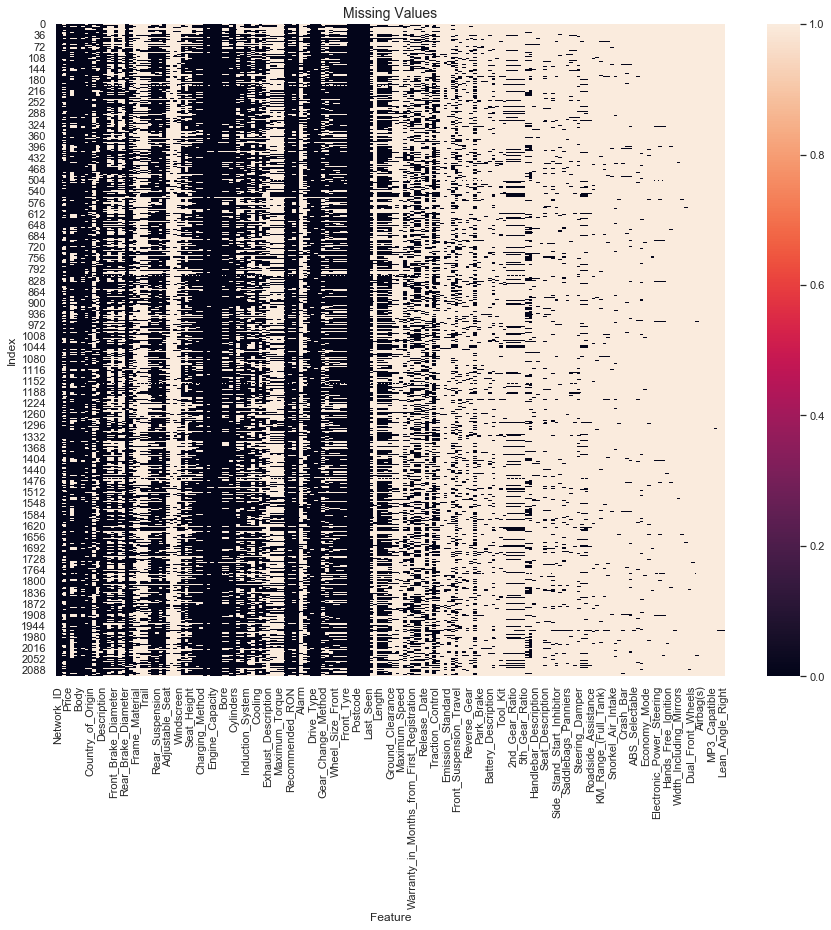

In [23]:
# Display missing values as a heatmap, where the hot part represents missing data
def missing_heatmap(df):
    fig, ax = plt.subplots(figsize=(15,12))
    sns.heatmap(df.isnull(), cbar=True, ax=ax)
    plt.xlabel('Feature')
    plt.ylabel('Index')
    plt.title('Missing Values', fontsize=14)
    plt.show()

missing_heatmap(df)

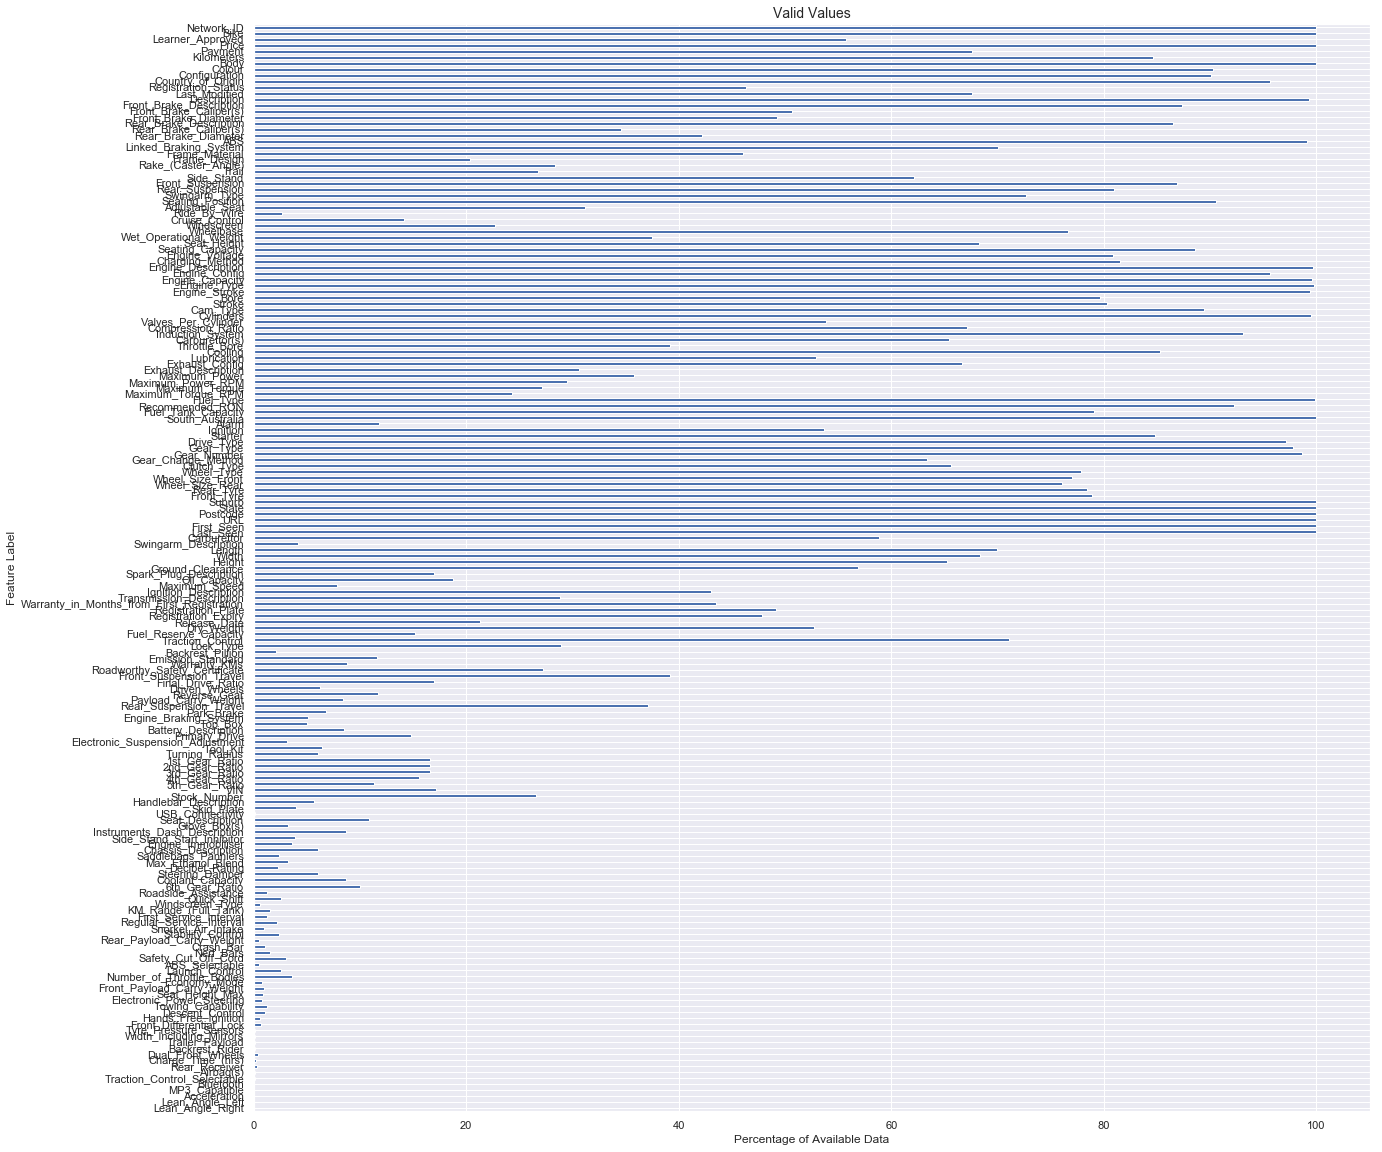

In [24]:
# Alternatively display number of valid data as a percentage in a bar chart
def missing_bar(df):
    total = df.shape[0]
    missing = (total - df.isnull().sum())/total * 100
    missing.plot(kind='barh',figsize=(20,20))
    plt.gca().invert_yaxis()
    plt.xlabel('Percentage of Available Data')
    plt.ylabel('Feature Label')
    plt.title('Valid Values', fontsize=14)
    plt.show()

missing_bar(df)


In [25]:
missing = df.isnull().sum()/df.shape[0] * 100
print('{}% of data is missing '.format(round(missing.sum()/len(df.columns),3)))
df.shape

59.619% of data is missing 


(2108, 181)

#### Dealing with Missing Values
We currently only have **60%** of the potential data that could be available. This would need to be improved if we want to be able to make any predictions on the data.

We can increase this by removing some of the features that dont provide any variation, ie. only 1 unique value. But first, we should see if we can impute values for any of the features.




In [26]:
# Amalgamate any features that can be.

# Generate list of features to look at
# - featuers with less than ~80% data

minimum_null_threshold = 0.8 * df.shape[0]

for col in list(df.columns):
    if (df[col].isnull().sum() > minimum_null_threshold):
        
         print (col)
        
        

Ride_By_Wire
Cruise_Control
Alarm
Swingarm_Description
Spark_Plug_Description
Oil_Capacity
Maximum_Speed
Fuel_Reserve_Capacity
Backrest_Pillion
Emission_Standard
Warranty_KMs
Final_Drive_Ratio
Driven_Wheels
Reverse_Gear
Payload_Carry_Weight
Park_Brake
Engine_Braking_System
Top_Box
Battery_Description
Primary_Drive
Electronic_Suspension_Adjustment
Tool_Kit
Turning_Radius
1st_Gear_Ratio
2nd_Gear_Ratio
3rd_Gear_Ratio
4th_Gear_Ratio
5th_Gear_Ratio
VIN
Handlebar_Description
Skid_Plate
USB_Connectivity
Seat_Description
Glove_Box(s)
Instruments_Dash_Description
Side_Stand_Start_Inhibitor
Engine_Immobiliser
Chassis_Description
Saddlebags_Panniers
Max_Ethanol_Blend
Decibel_Rating
Steering_Damper
Coolant_Capacity
6th_Gear_Ratio
Roadside_Assistance
Quick_Shift
Windscreen_Type
KM_Range_(Full_Tank)
First_Service_Interval
Regular_Service_Interval
Snorkel_Air_Intake
Stability_Control
Rear_Payload_Carry_Weight
Crash_Bar
Nerf_Bars
Safety_Cut_Off_Cord
ABS_Selectable
Launch_Control
Number_of_Throttle_Bod

In [29]:
remove = ['1st_Gear_Ratio','2nd_Gear_Ratio','3rd_Gear_Ratio','4th_Gear_Ratio','5th_Gear_Ratio','6th_Gear_Ratio']
impute = ['ABS_Selectable ','Adjustable_Front_Footrests','Airbag(s)','Alarm','Backrest_Pillion',
          'Backrest_Rider','Bluetooth','CD_Player','Coolant_Capacity','Crash_Bar','Cruise_Control',
          'Cup_Holders','Descent_Control','Driver_Restraint','Economy_Mode','Engine_Immobiliser',
          'Front_Differential_Lock','Front_Payload_Carry_Weight','Fuel_Reserve_Capacity',
          'Heated_Seats','MP3_Capatible','Max_Ethanol_Blend','Oil_Capacity','Park_Brake',
          'Passenger(s)_Restraint','Payload_Carry_Weight','Rear_Cargo_Bed_Depth',
          'Rear_Cargo_Bed_Length','Rear_Cargo_Bed_Width','Rear_Payload_Carry_Weight',
          'Reverse_Gear','Rider_Pillion_Communication','Roof','Saddlebags_Panniers',
          'Snorkel_Air_Intake','Winch']
          
randomforest_imoute = ['Hands_Free_Ignition', 'Number_of_Throttle_Bodies']


In [229]:
# A feature is only useful when there is a variety labels available in each feature.
# - Maybe drop all features (columns) that have less than 5 unique values. (5 is an arbitrary number)
# - Need to know the distribution of these unique values for each feature. If there is a small number 
#   of values, but evenly or normally distributed, these may provide a reasonable feature for machine learning.

from tabulate import tabulate

total = df.shape[0]
for col in list(df.columns):
    if len(df[col].unique()) < 5:
        print ('{0}: unique: {1}; available data: {2}'.format(col,len(df[col].unique()),round((1-df[col].isnull().sum()/total)*100,3)))
        #print (tabulate([[col, len(df[col].unique()),round((1-df[col].isnull().sum()/total)*100,3)]]))


ABS: unique: 4; available data: 98.145
ABS_Selectable: unique: 3; available data: 1.546
Acceleration: unique: 3; available data: 0.048
Adjustable_Front_Footrests: unique: 3; available data: 0.666
Adjustable_Seat: unique: 3; available data: 31.518
Airbag(s): unique: 2; available data: 0.095
Alarm: unique: 4; available data: 10.894
Australian_Capital_Territory: unique: 1; available data: 100.0
Backrest_Pillion: unique: 4; available data: 3.568
Backrest_Rider: unique: 3; available data: 0.19
Bluetooth: unique: 2; available data: 0.119
CD_Player: unique: 2; available data: 0.024
Charge_Time_(hrs): unique: 2; available data: 0.167
Clutch_Diameter: unique: 4; available data: 0.238
Crash_Bar: unique: 3; available data: 0.809
Cruise_Control: unique: 4; available data: 12.036
Cup_Holders: unique: 2; available data: 0.214
Descent_Control: unique: 2; available data: 0.333
Driver_Restraint: unique: 2; available data: 0.048
Dual_Front_Wheels: unique: 4; available data: 0.452
Electronic_Power_Steeri

In [30]:
# FEATURE REDUCTION
# Drop the features that too many null values
minimum_null_threshold = 0.8 * df.shape[0]

drop_features = []
for col in list(df.columns):
    if (df[col].isnull().sum() > minimum_null_threshold):
        
        drop_features.append(col)
        
        
before = len(df.columns)
df.drop(drop_features, axis=1, inplace=True)
after = len(df.columns)

print (drop_features)
print ('Before: {}, After: {}'.format(before, after))

['Ride_By_Wire', 'Cruise_Control', 'Alarm', 'Swingarm_Description', 'Spark_Plug_Description', 'Oil_Capacity', 'Maximum_Speed', 'Fuel_Reserve_Capacity', 'Backrest_Pillion', 'Emission_Standard', 'Warranty_KMs', 'Final_Drive_Ratio', 'Driven_Wheels', 'Reverse_Gear', 'Payload_Carry_Weight', 'Park_Brake', 'Engine_Braking_System', 'Top_Box', 'Battery_Description', 'Primary_Drive', 'Electronic_Suspension_Adjustment', 'Tool_Kit', 'Turning_Radius', '1st_Gear_Ratio', '2nd_Gear_Ratio', '3rd_Gear_Ratio', '4th_Gear_Ratio', '5th_Gear_Ratio', 'VIN', 'Handlebar_Description', 'Skid_Plate', 'USB_Connectivity', 'Seat_Description', 'Glove_Box(s)', 'Instruments_Dash_Description', 'Side_Stand_Start_Inhibitor', 'Engine_Immobiliser', 'Chassis_Description', 'Saddlebags_Panniers', 'Max_Ethanol_Blend', 'Decibel_Rating', 'Steering_Damper', 'Coolant_Capacity', '6th_Gear_Ratio', 'Roadside_Assistance', 'Quick_Shift', 'Windscreen_Type', 'KM_Range_(Full_Tank)', 'First_Service_Interval', 'Regular_Service_Interval', 'Sno

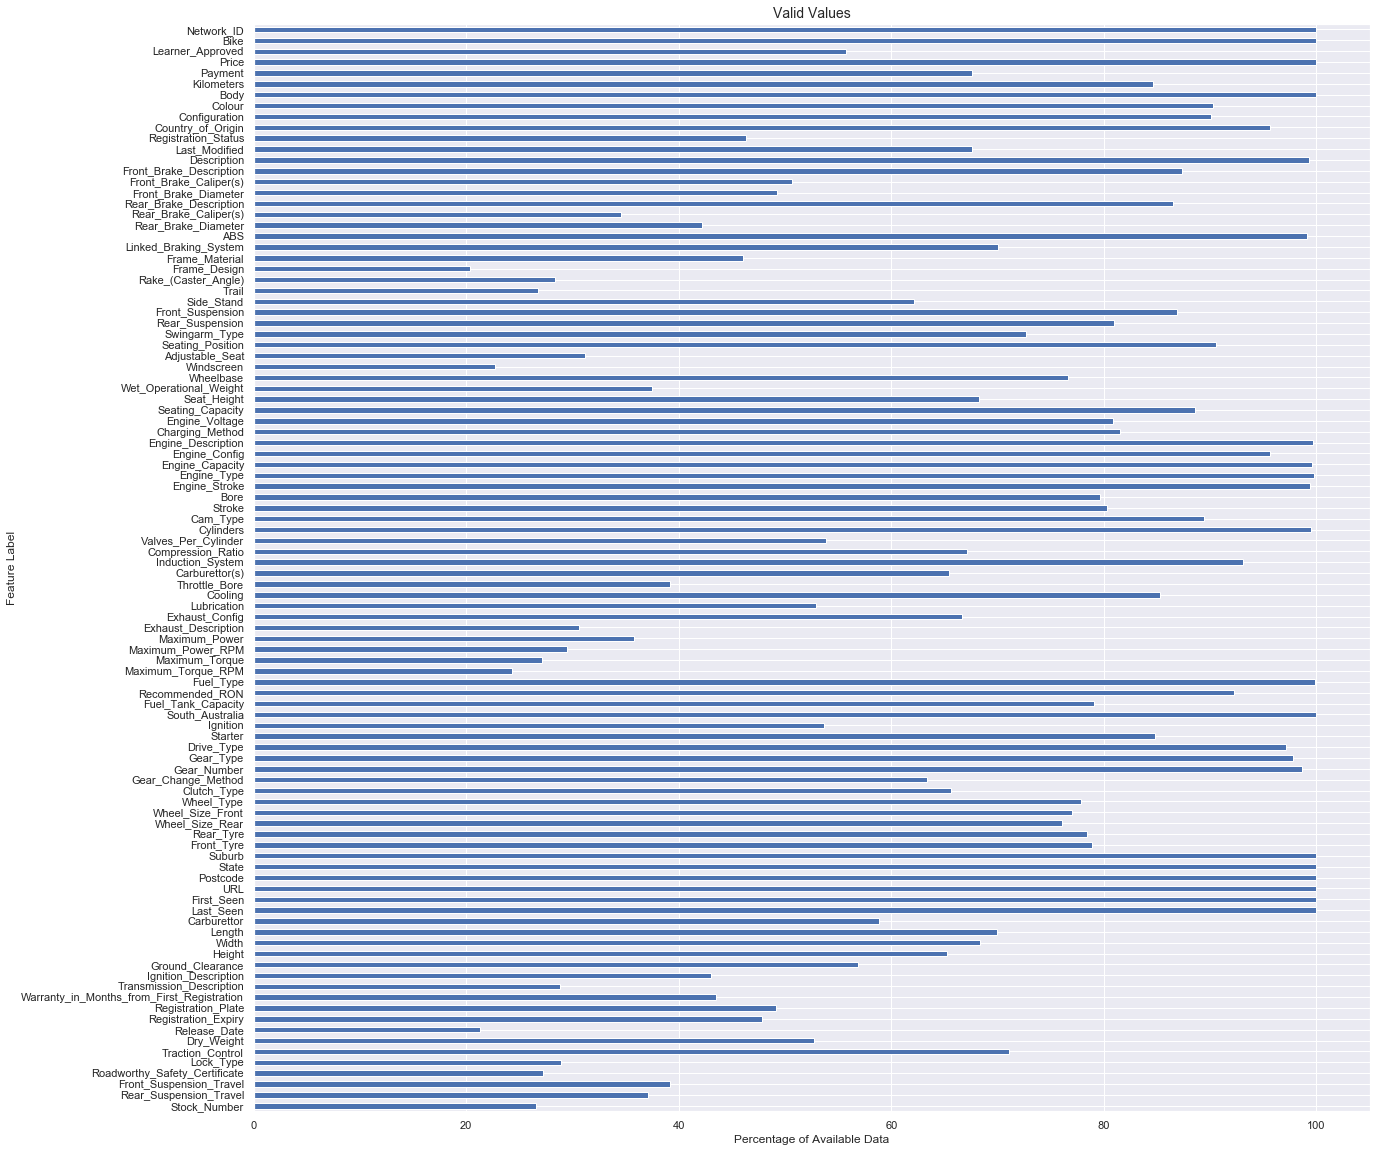

31.113% of data is missing 


In [32]:

missing_bar(df)
missing = df.isnull().sum()/df.shape[0] * 100
print('{}% of data is missing '.format(round(missing.sum()/len(df.columns),3)))


In [33]:
# Combine features - before removing


In [34]:
df.shape[0]

2108

In [35]:
df.index[-1]

2107

In [36]:
df['ABS'].isnull().sum()/df.shape[0]*100


0.9013282732447818